# KMeans Clustering comparison to Deep Learning

Here we apply K-means clustering to segment the images of Eberswalde fan. We want to see how well this simple method can do for segmenting the images and identify some ideal parameters that perform best.

In [25]:
#%pip install --force-reinstall numpy
#%pip install --force-reinstall rasterio rioxarray
#%pip install numpy==1.23.5

import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to your working directory to store the images
data_path = "/Users/GLaDOS/Documents/GitHub/MarsFans_OLD_CLONES/MLGEO2024_MarsFans/data_lvl3_ai-ready/"

In [26]:
#blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
#blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

#dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
#nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

#hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
#hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
#hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
#hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
#hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [ctxDEM, ctxIMG, ctxSLOPE]
training_names = ['ctxDEM', 'ctxIMG', 'ctxSLOPE']

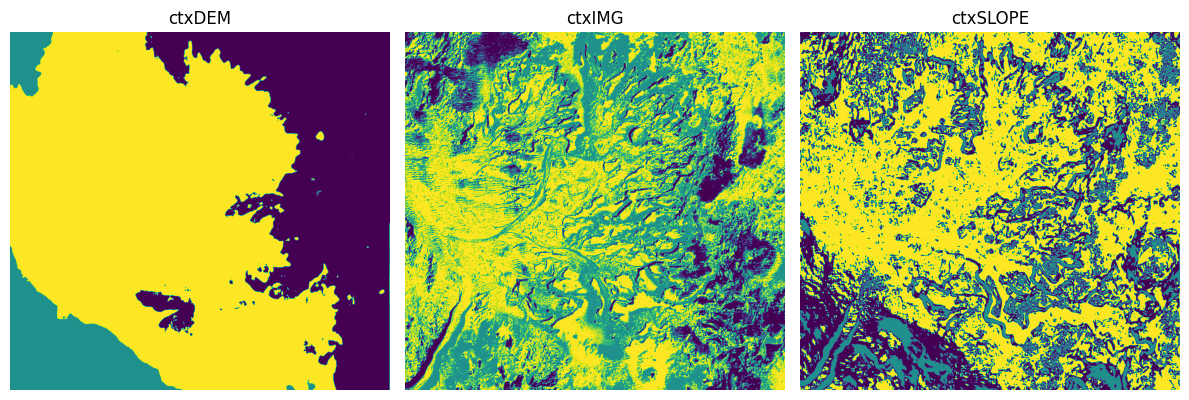

In [27]:
# Set the number of images per row, 3 because there are 3 images
n_cols = 3
n_rows = len(clustered_imgs) // n_cols + int(len(clustered_imgs) % n_cols > 0)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Loop through the training images and plot them
for i, ax in enumerate(axes.flat):
    if i < len(clustered_imgs):
        img = clustered_imgs[i]  # Clustered images are already 2D arrays
        ax.imshow(img, cmap='viridis')  # You can choose a different colormap if desired
        ax.set_title(training_names[i])
        ax.axis('off')  # Turn off the axes
    else:
        ax.axis('off')  # Turn off any unused subplots

plt.tight_layout()
plt.show()

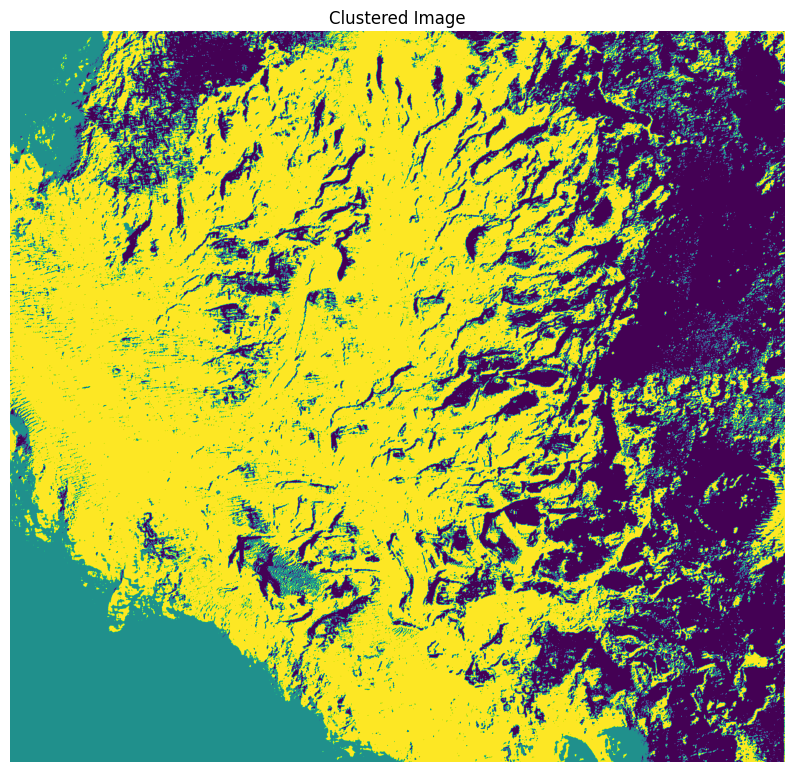

In [28]:
# Define the number of clusters, 3, 4, or 5
n_clusters = 3  # Adjust this number based on the desired number of feature classes

# Combine the images into a multi-band image
subset_imgs = [ctxDEM, ctxIMG, ctxSLOPE]

multi_band_image = np.stack([img.values[0] for img in subset_imgs], axis=-1)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels)

# Reshape the clustered labels back into the original 2D shape
clustered_image = kmeans.labels_.reshape(multi_band_image.shape[:2])

# Plot the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image')
plt.axis('off')
plt.show()

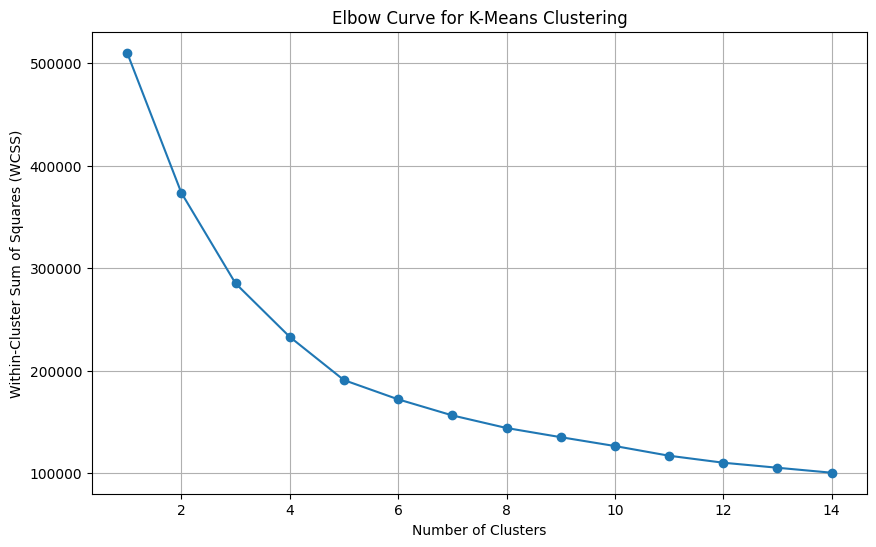

In [29]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve for K-Means Clustering')
plt.grid(True)
plt.show()

### F1 Score Calculations

In [34]:
def simple_overlap(pred,gt,plotting=False):
    
    LF0 = pred[gt == 0]
    LF1 = pred[gt == 1]
    LF2 = pred[gt == 2]
    LF3 = pred[gt == 3]
    LF4 = pred[gt == 4]

    cluster_num = len(np.unique(pred))
    totals = np.zeros((cluster_num,5))
    feature_map = np.zeros(cluster_num)
    # print(cluster_num)
    mapped = pred.copy()
    mapped_static = pred.copy()
    for i in range(cluster_num):
        totals[i,0] = np.sum(LF0 == i)
        totals[i,1] = np.sum(LF1 == i)
        totals[i,2] = np.sum(LF2 == i)
        totals[i,3] = np.sum(LF3 == i)
        totals[i,4] = np.sum(LF4 == i)
        feature_map[i] = [k for k, x in enumerate(totals[i,:] == np.max(totals[i,:])) if x][0]
        # print("Loop: ", i, "Feature Map: ", feature_map[i])
        mapped[mapped_static == i] = feature_map[i]

    valid_mask = ~np.isnan(pred)
    pred_nonan_flat = pred[valid_mask].ravel()
    gt_nonan_flat = gt[valid_mask].ravel()

    f1 = f1_score(gt_nonan_flat, pred_nonan_flat, average='weighted', zero_division=0)
    print(f'F1 Score: {f1:.4f}')

    if plotting:
        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        plot_vmin = 0
        plot_vmax_pred = np.nanmax(np.unique(pred))
        plot_vmax_gt = np.nanmax(np.unique(gt))

        # Plot the clustered image
        axes[0].imshow(pred, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_pred)
        axes[0].set_title('Clustered Image')
        axes[0].axis('off')

        # Plot the ground truth image
        axes[1].imshow(gt, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_gt)
        axes[1].set_title('Ground Truth Image')
        axes[1].axis('off')

        # Plot the mapped image
        axes[2].imshow(mapped, cmap='jet', vmin=plot_vmin, vmax=plot_vmax_gt)
        axes[2].set_title('Mapped Image')
        axes[2].axis('off')
    
    return mapped, feature_map, f1

### Single Image F1 Score Calculation

Accuracy: 0.3511
Precision: 0.5392
Recall: 0.3511
F1 Score: 0.3849


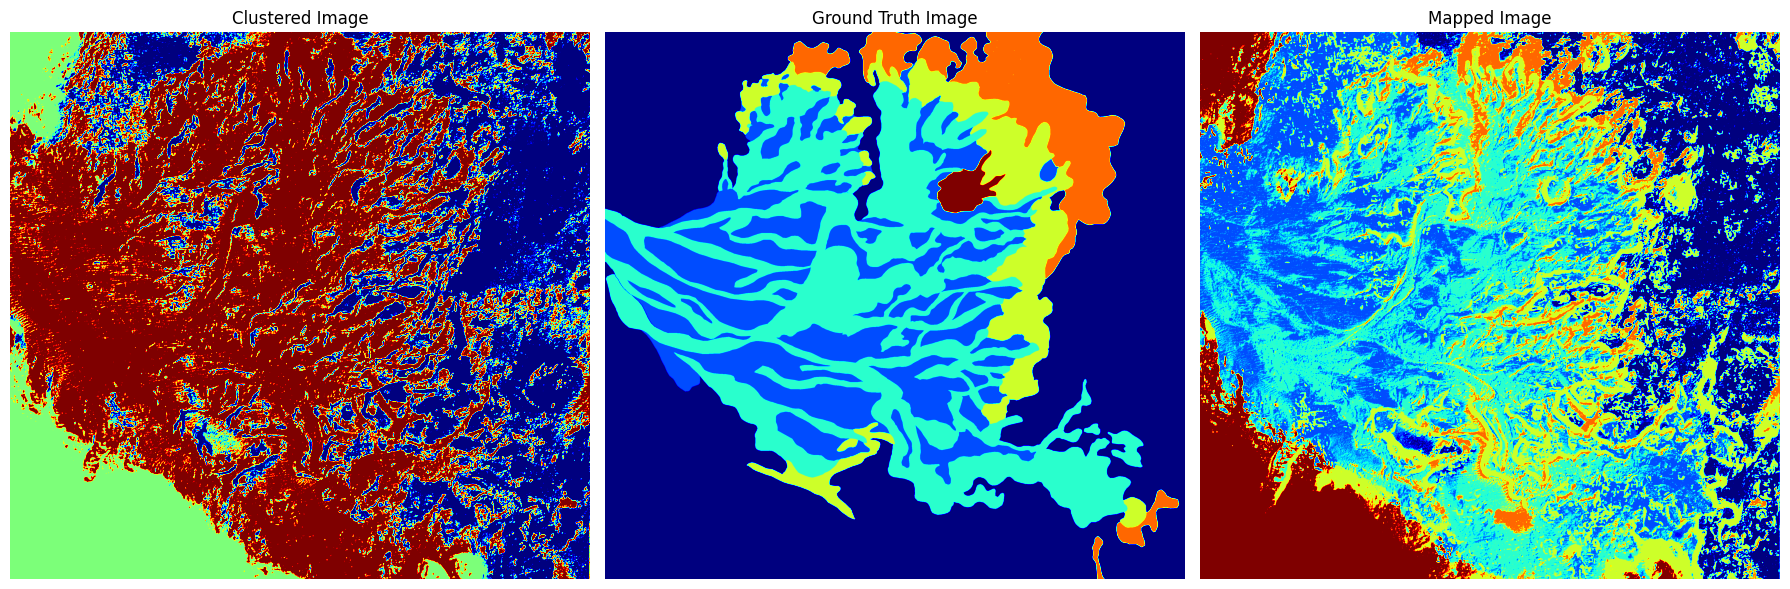

In [31]:

from scipy.cluster.hierarchy import linkage, fcluster

# Compute the contingency matrix (confusion matrix)
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

label_map = rxr.open_rasterio("/Users/GLaDOS/Documents/GitHub/MLGEO2024_MarsFans/data/label/validation_map.tif", cache=False)

clustered_image_flat = multi_band_image_kmeans[8].ravel()
ground_truth_labels_flat = label_map.values[0].ravel()

contingency_matrix = confusion_matrix(ground_truth_labels_flat, clustered_image_flat)
# Perform hierarchical clustering on the contingency matrix to combine clusters
Z = linkage(contingency_matrix.T, method='ward')
num_ground_truth_labels = len(np.unique(label_map.values[0]))
combined_clusters = fcluster(Z, t=num_ground_truth_labels, criterion='maxclust')

# Create a mapping from original clusters to combined clusters
cluster_combination_mapping = {i: combined_clusters[i] for i in range(len(combined_clusters))}

# Map the original clusters to the combined clusters
combined_clustered_image_flat = np.vectorize(cluster_combination_mapping.get)(clustered_image_flat)
combined_clustered_image_flat = combined_clustered_image_flat - 1  # Shift the labels to start from 0

# Compute the new contingency matrix with combined clusters
new_contingency_matrix = confusion_matrix(ground_truth_labels_flat, combined_clustered_image_flat)

# Apply the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(-new_contingency_matrix)

# Create a mapping from combined clusters to ground truth labels
combined_cluster_to_label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Map the combined clusters to the ground truth labels
mapped_clusters = np.vectorize(combined_cluster_to_label_mapping.get)(combined_clustered_image_flat)

# Compute evaluation metrics
accuracy = accuracy_score(ground_truth_labels_flat, mapped_clusters)
precision = precision_score(ground_truth_labels_flat, mapped_clusters, average='weighted')
recall = recall_score(ground_truth_labels_flat, mapped_clusters, average='weighted')
f1 = f1_score(ground_truth_labels_flat, mapped_clusters, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the clustered image
axes[0].imshow(clustered_image, cmap='jet')
axes[0].set_title('Clustered Image')
axes[0].axis('off')

# Plot the ground truth image
axes[1].imshow(label_map.values[0], cmap='jet')
axes[1].set_title('Ground Truth Image')
axes[1].axis('off')

# Plot the mapped image
mapped_image = mapped_clusters.reshape(clustered_image.shape)
axes[2].imshow(mapped_image, cmap='jet')
axes[2].set_title('Mapped Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()